# Working with shapefiles

This notebook shows some lower-level functionality in `flopy` for working with shapefiles
including:
* `recarray2shp` convience function for writing a numpy record array to a shapefile
* `shp2recarray` convience function for quickly reading a shapefile into a numpy recarray
* `utils.geometry` classes for writing shapefiles of model input/output. For example, quickly writing a shapefile of model cells with errors identified by the checker
* examples of how the `Point` and `LineString` classes can be used to quickly plot pathlines and endpoints from MODPATH (these are also used by the `PathlineFile` and `EndpointFile` classes to write shapefiles of this output)

In [1]:
import os
import sys
import shutil
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings


# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

from flopy.utils.geometry import Polygon, LineString, Point
from flopy.export.shapefile_utils import recarray2shp, shp2recarray
from flopy.utils.modpathfile import PathlineFile, EndpointFile
from flopy.utils import geometry

warnings.simplefilter("ignore", UserWarning)
print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
numpy version: 1.24.2
matplotlib version: 3.6.3
flopy version: 3.3.7


### write a numpy record array to a shapefile
in this case, we want to visualize output from the checker  
first make a toy model

In [2]:
temp_dir = TemporaryDirectory()
workspace = temp_dir.name

m = flopy.modflow.Modflow("toy_model", model_ws=workspace)
botm = np.zeros((2, 10, 10))
botm[0, :, :] = 1.5
botm[1, 5, 5] = 4  # negative layer thickness!
botm[1, 6, 6] = 4
dis = flopy.modflow.ModflowDis(
    nrow=10, ncol=10, nlay=2, delr=100, delc=100, top=3, botm=botm, model=m
)

### set coordinate information

In [3]:
grid = m.modelgrid
grid.set_coord_info(xoff=600000, yoff=5170000, crs="EPSG:26715", angrot=45)

In [4]:
chk = dis.check()
chk.summary_array


DIS PACKAGE DATA VALIDATION:
  2 Errors:
    2 instances of zero or negative thickness

  Checks that passed:
    thin cells (less than checker threshold of 1.0)
    nan values in top array
    nan values in bottom array



rec.array([('Error', 'DIS', 1, 5, 5, -2.5, 'zero or negative thickness'),
           ('Error', 'DIS', 1, 6, 6, -2.5, 'zero or negative thickness')],
          dtype=[('type', 'O'), ('package', 'O'), ('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('value', '<f8'), ('desc', 'O')])

### make geometry objects for the cells with errors  
*  geometry objects allow the shapefile writer to be simpler and agnostic about the kind of geometry

In [5]:
get_vertices = (
    m.modelgrid.get_cell_vertices
)  # function to get the referenced vertices for a model cell
geoms = [Polygon(get_vertices(i, j)) for i, j in chk.summary_array[["i", "j"]]]

In [6]:
geoms[0].type

'Polygon'

In [7]:
geoms[0].exterior

((600000.0, 5170707.106781187),
 (600070.7106781186, 5170777.817459305),
 (600141.4213562373, 5170707.106781187),
 (600070.7106781186, 5170636.396103068))

In [8]:
geoms[0].bounds

(600000.0, 5170636.396103068, 600141.4213562373, 5170777.817459305)

<AxesSubplot: >

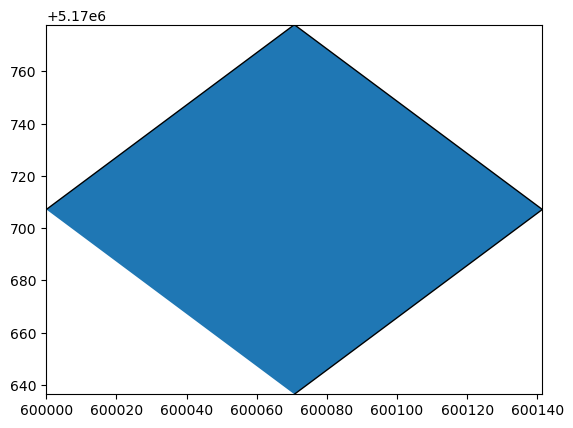

In [9]:
geoms[0].plot()  # this feature requires descartes

### write the shapefile  
* the projection (.prj) file can be written using an epsg code  
* or copied from an existing .prj file

In [10]:
from pathlib import Path

recarray2shp(
    chk.summary_array, geoms, os.path.join(workspace, "test.shp"), crs=26715
)
shape_path = os.path.join(workspace, "test.prj")

wrote ../../../../../../../Users/aleaf/Documents/GitHub/flopy/.docs/Notebooks


In [11]:
shutil.copy(shape_path, os.path.join(workspace, "26715.prj"))
recarray2shp(
    chk.summary_array,
    geoms,
    os.path.join(workspace, "test.shp"),
    prjfile=os.path.join(workspace, "26715.prj"),
)

wrote ../../../../../../../Users/aleaf/Documents/GitHub/flopy/.docs/Notebooks


### read it back in
* flopy geometry objects representing the shapes are stored in the 'geometry' field

In [12]:
ra = shp2recarray(os.path.join(workspace, "test.shp"))
ra

rec.array([('Error', 'DIS', 1, 5, 5, -2.5, 'zero or negative thickness', <flopy.utils.geometry.Polygon object at 0x10af0bf10>),
           ('Error', 'DIS', 1, 6, 6, -2.5, 'zero or negative thickness', <flopy.utils.geometry.Polygon object at 0x10afae610>)],
          dtype=[('type', 'O'), ('package', 'O'), ('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('value', '<f8'), ('desc', 'O'), ('geometry', 'O')])

<AxesSubplot: >

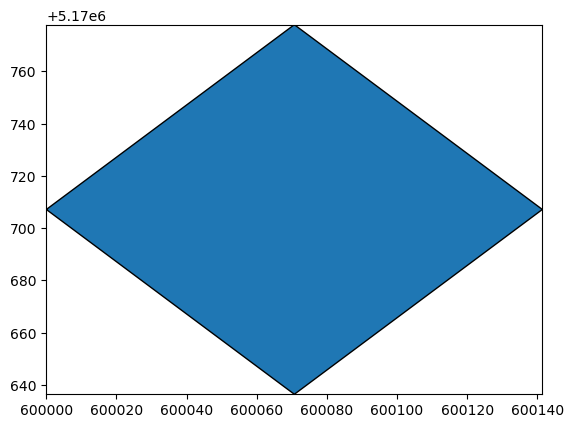

In [13]:
ra.geometry[0].plot()

## Other geometry types

### Linestring  
* create geometry objects for pathlines from a MODPATH simulation
* plot the paths using the built in plotting method

In [14]:
pthfile = PathlineFile("../../examples/data/mp6/EXAMPLE-3.pathline")
pthdata = pthfile._data.view(np.recarray)

In [15]:
length_mult = 1.0  # multiplier to convert coordinates from model to real world
rot = 0  # grid rotation

particles = np.unique(pthdata.particleid)
geoms = []
for pid in particles:
    ra = pthdata[pthdata.particleid == pid]

    x, y = geometry.rotate(
        ra.x * length_mult, ra.y * length_mult, grid.xoffset, grid.yoffset, rot
    )
    z = ra.z
    geoms.append(LineString(list(zip(x, y, z))))

In [16]:
geoms[0]

<AxesSubplot: >

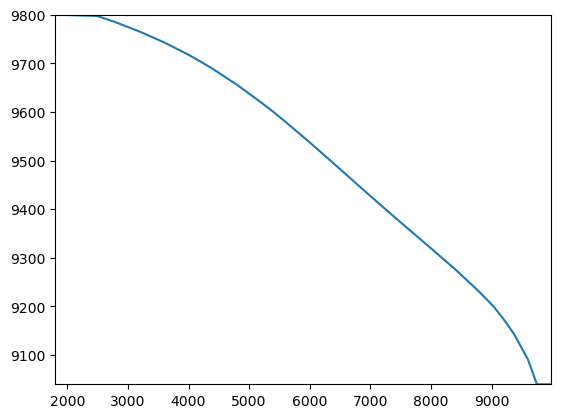

In [17]:
geoms[0].plot()

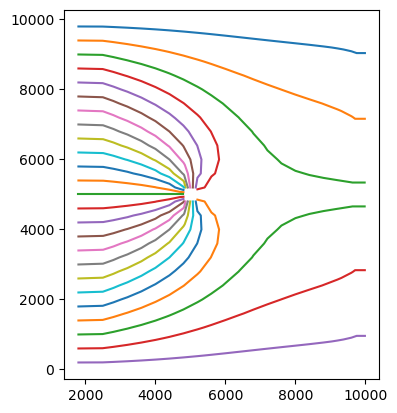

In [18]:
fig, ax = plt.subplots()
for g in geoms:
    g.plot(ax=ax)
ax.autoscale()
ax.set_aspect(1)

## Points

In [19]:
eptfile = EndpointFile("../../examples/data/mp6/EXAMPLE-3.endpoint")
eptdata = eptfile.get_alldata()

In [20]:
x, y = geometry.rotate(
    eptdata["x0"] * length_mult,
    eptdata["y0"] * length_mult,
    grid.xoffset,
    grid.yoffset,
    rot,
)
z = eptdata["z0"]

geoms = [Point(x[i], y[i], z[i]) for i in range(len(eptdata))]

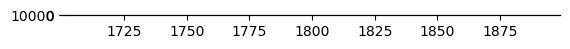

In [21]:
fig, ax = plt.subplots()
for g in geoms:
    g.plot(ax=ax)
ax.autoscale()
ax.set_aspect(2e-6)

In [22]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass